# Imports

In [1]:
import gymnasium as gym
import pandas as pd
from gymnasium import Wrapper
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict, Optional
import random
import time

In [2]:

# Set random seeds for reproducibility
RAND_SEED = 41432

# Wrappers

## MetricsWrapper
MetricsWrapper: Tracks episode metrics (returns, lengths, success rate)

In [3]:
class MetricsWrapper(Wrapper):
    """
    Wrapper to track per-episode metrics:
    - Episode return (cumulative reward)
    - Episode length (number of steps)
    - Success rate (reached goal)
    - Throughput (episodes per second)
    """

    def __init__(self, env):
        super().__init__(env)
        self.episode_rewards = []
        self.episode_org_rewards = []
        self.episode_lengths = []
        self.episode_successes = []
        self.current_episode_reward = 0
        self.current_episode_org_reward = 0
        self.current_episode_length = 0
        self.start_time = None
        self.total_episodes = 0
        self.desc = env.unwrapped.desc
        self.ncol = env.unwrapped.ncol

    def __has_reached_goal(self, state):
        r = state // self.ncol
        c = state % self.ncol
        return self.desc[r, c] == b'G'

    def reset(self, **kwargs):
        if self.start_time is None:
            self.start_time = time.time()
        self.current_episode_reward = 0
        self.current_episode_org_reward = 0
        self.current_episode_length = 0
        return self.env.reset(**kwargs)

    def step(self, action, episode_num):
        obs, shaped_reward, terminated, truncated, info, org_reward = self.env.step(action, episode_num=episode_num)

        self.current_episode_reward += shaped_reward
        self.current_episode_org_reward += org_reward
        self.current_episode_length += 1

        if terminated or truncated:
            self.episode_rewards.append(self.current_episode_reward)
            self.episode_org_rewards.append(self.current_episode_org_reward)
            self.episode_lengths.append(self.current_episode_length)
            self.episode_successes.append(1 if self.__has_reached_goal(obs) else 0)
            self.total_episodes += 1

        return obs, shaped_reward, terminated, truncated, info

    def get_metrics(self) -> Dict:
        """Return current metrics."""
        elapsed_time = time.time() - self.start_time if self.start_time else 0
        return {
            'total_episodes': self.total_episodes,
            'mean_reward': np.mean(self.episode_rewards) if self.episode_rewards else 0,
            'mean_length': np.mean(self.episode_lengths) if self.episode_lengths else 0,
            'success_rate': np.mean(self.episode_successes) if self.episode_successes else 0,
            'throughput': self.total_episodes / elapsed_time if elapsed_time > 0 else 0,
            'episode_rewards': self.episode_rewards,
            'episode_org_rewards': self.episode_org_rewards,
            'episode_lengths': self.episode_lengths,
            'episode_successes': self.episode_successes
        }

    def reset_metrics(self):
        """Reset all tracked metrics."""
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_successes = []
        self.total_episodes = 0
        self.start_time = time.time()

## RewardShapingWrapper
RewardShapingWrapper: Optional reward shaping (can be enabled/disabled)

In [4]:
class RewardShapingWrapper(Wrapper):
    """
    Optional wrapper for reward shaping.
    Can be enabled/disabled to compare performance.
    """

    def __init__(self, env,
                 goal_position: Tuple[int, int] = None,
                 map_size: int = 8, custom_reward_func = None,
                 gamma = 0.95,
                 shaping_decay = 1.0,
                 shaping_strength=0.01):
        super().__init__(env)
        self.map_size = map_size
        # Default goal position (bottom-right for our map)
        self.goal_position = goal_position or (map_size - 1, map_size - 1)
        self.prev_state = None
        self.custom_reward_func = custom_reward_func
        self.gamma = gamma
        self.shaping_decay = shaping_decay
        self.shaping_strength = shaping_strength

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.prev_state = obs
        return obs, info

    def _state_to_pos(self, state: int) -> Tuple[int, int]:
        """Convert state index to (row, col) position."""
        return (state // self.map_size, state % self.map_size)

    def step(self, action, episode_num = 0):
        obs, reward, terminated, truncated, info = self.env.step(action)

        shaped_reward = reward
        if self.custom_reward_func is not None:
            shaped_reward = (self.shaping_decay ** (episode_num-1)) * self.custom_reward_func(self.env, self.prev_state, action, obs,
                                                                                                    gamma=self.gamma, shaping_strength=self.shaping_strength)

        self.prev_state = obs
        return obs, shaped_reward, terminated, truncated, info, reward

    def step_cost_function(env, curr_state, action, next_state, gamma, shaping_strength):
      return -0.01

    def negative_potential_reward(env, curr_state, action, next_state, gamma, shaping_strength):
      '''
      Reward shaping based on negative potential.
      '''
      nrow = env.unwrapped.nrow
      ncol = env.unwrapped.ncol
      # the goal is always at the bottom right coner
      goal_state = nrow * ncol - 1
      goal_pos = (nrow - 1, ncol - 1)
      curr_pos = (curr_state // nrow, curr_state % ncol)
      next_pos = (next_state // nrow, next_state % ncol)

      # the goal has no potential
      if next_state == goal_state:
        return 0

      # as the state is closer, the potential will be closer to zero
      curr_potential = -(abs(curr_pos[0] - goal_pos[0]) + abs(curr_pos[1] - goal_pos[1]))
      next_potential = -(abs(next_pos[0] - goal_pos[0]) + abs(next_pos[1] - goal_pos[1]))

      return shaping_strength * ((gamma * next_potential) - curr_potential)

    def safe_position_reward(env, curr_state, action, next_state, gamma, shaping_strength):

      desc = env.unwrapped.desc
      nrow = env.unwrapped.nrow
      ncol = env.unwrapped.ncol

      state_to_pos = lambda state: (state // ncol, state % ncol)

      def min_distance_to_holes(state):
          row, col = state_to_pos(state)
          min_dist = float('inf')

          for r in range(nrow):
              for c in range(ncol):
                  # if a
                  if desc[r, c] == b'H':
                      dist = abs(row - r) + abs(col - c)
                      min_dist = min(min_dist, dist)

          return min_dist if min_dist != float('inf') else nrow + ncol

      hole_dist = min_distance_to_holes(next_state)
      if hole_dist == 0:  # On a hole (shouldn't happen in normal step)
          safety = -5.0
      elif hole_dist == 1:  # Adjacent to hole (dangerous!)
          safety = -0.1
      else:  # Safe distance
          safety = 0.1

      return safety



    def safe_progress_reward(env, curr_state, action, next_state, gamma, shaping_strength):
      """
      Reward shaping based on progress toward goal while avoiding holes.

      Combines:
      - Progress toward goal (Manhattan distance improvement)
      - Safety bonus (distance from holes)
      """
      desc = env.unwrapped.desc
      nrow = env.unwrapped.nrow
      ncol = env.unwrapped.ncol
      # the goal is always at the bottom right coner
      goal_state = nrow * ncol - 1

      state_to_pos = lambda state: (state // ncol, state % ncol)

      def manhattan_distance(state, target):
          s_row, s_col = state_to_pos(state)
          t_row, t_col = state_to_pos(target)
          return abs(s_row - t_row) + abs(s_col - t_col)

      def min_distance_to_holes(state):
          row, col = state_to_pos(state)
          min_dist = float('inf')

          for r in range(nrow):
              for c in range(ncol):
                  # if a
                  if desc[r, c] == b'H':
                      dist = abs(row - r) + abs(col - c)
                      min_dist = min(min_dist, dist)

          return min_dist if min_dist != float('inf') else nrow + ncol

      # 1. Progress toward goal
      old_dist = manhattan_distance(curr_state, goal_state)
      new_dist = manhattan_distance(next_state, goal_state)
      progress = (old_dist - new_dist)

      # 2. Safety bonus (being far from holes is good)
      hole_dist = min_distance_to_holes(next_state)
      if hole_dist == 0:  # On a hole (shouldn't happen in normal step)
          safety = -5.0
      elif hole_dist == 1:  # Adjacent to hole (dangerous!)
          safety = -0.1
      else:  # Safe distance
          safety = 0.1

      # Total shaped reward
      total = progress + safety

      return total

# Main Classes

## create_frozen_lake_env

In [5]:
def create_frozen_lake_env(custom_map: List[str] = None,
                           is_slippery: bool = True,
                           max_episode_steps: int = 200,
                           custom_reward_func = None,
                           gamma = 0.95,
                           shaping_decay = 0.95,
                           shaping_strength = 0.01,
                           map_size_n: int = 8) -> gym.Env:
    """
    Create a Frozen Lake environment with custom wrappers.

    Args:
        custom_map: Custom map description (list of strings), if None the map will be random
        is_slippery: Whether the ice is slippery (True = success_rate ~0.33 per direction)
        max_episode_steps: Maximum steps per episode

    Returns:
        Wrapped Gymnasium environment
    """
    # Create base environment
    if custom_map is None:
      env_map = generate_random_map(size=map_size_n, p=0.8, seed=RAND_SEED)
    else:
      env_map = custom_map

    env = gym.make(
        'FrozenLake-v1',
        desc=env_map,
        is_slippery=is_slippery,
        success_rate=0.7,
        max_episode_steps=max_episode_steps,
        render_mode=None  # Set to 'human' for visualization
    )

    # Apply wrappers (order matters!)
    # First: Reward shaping (modifies rewards)
    env = RewardShapingWrapper(env, map_size=map_size_n, custom_reward_func=custom_reward_func, gamma=gamma,
                               shaping_decay=shaping_decay, shaping_strength=shaping_strength)

    # Last: Metrics tracking (sees final rewards)
    env = MetricsWrapper(env)

    return env

# Test environment creation
# print("\n" + "=" * 50)
# print("ENVIRONMENT TEST")
# print("=" * 50)
# test_env = create_frozen_lake_env(CUSTOM_MAP_8x8, is_slippery=True)
# print(f"State space: {test_env.observation_space}")
# print(f"Action space: {test_env.action_space}")
# print(f"Number of states: {test_env.observation_space.n}")
# print(f"Number of actions: {test_env.action_space.n}")
# print(f"\nActions: 0=Left, 1=Down, 2=Right, 3=Up")
# test_env.close()

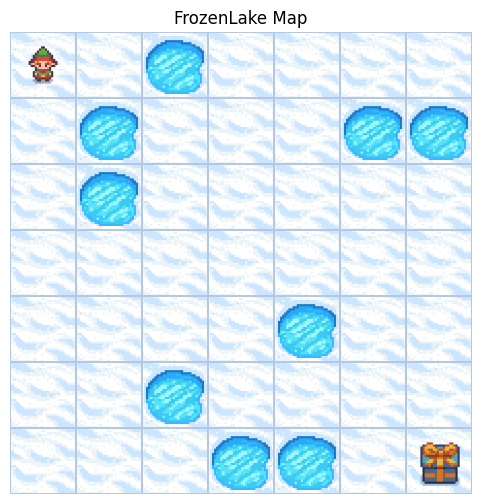

In [6]:
# Render the FrozenLake map using Gymnasium's built-in renderer
env = gym.make('FrozenLake-v1',
               desc=generate_random_map(size=7, p=0.8, seed=RAND_SEED),
               render_mode='rgb_array')

env.reset()

# Get the rendered image
rgb_array = env.render()

# Display it
plt.figure(figsize=(6, 6))
plt.imshow(rgb_array)
plt.axis('off')
plt.title('FrozenLake Map')
plt.show()

env.close()

## TrainableAgent

In [7]:
class TrainableAgent:
    """
    Agent with ε-greedy policy.

    Key features:
    - Q-table for state-action values
    - ε-greedy exploration strategy
    - Learning rate α (default = 0.1)
    - Discount factor γ (default = 1.0)
    - agentType [ "MC" - Every-Visit Monte Carlo , "SARSA" - SARSA(0) ] (default = "MC")
    """

    def __init__(self,
                 n_states: int,
                 n_actions: int,
                 alpha: float = 0.1,
                 gamma: float = 1.0,
                 epsilon: float = 0.1,
                 epsilon_min: float = 0.001,
                 epsilon_decay: float = 0,
                 agentType = "MC"):
        assert agentType in ("MC", "SARSA"), f"agentType must be 'MC or 'SARSA', not '{agentType}'"
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon_success = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay_mul = 1 - epsilon_decay
        self.useSARSA = agentType == "SARSA"

        # Initialize Q-table with zeros
        self.Q = np.zeros((n_states, n_actions))

        # Track visit counts for analysis
        self.visit_counts = np.zeros((n_states, n_actions))

    def select_action(self, state: int, training: bool = True) -> int:
        if training and np.random.random() < self.epsilon_success:
            # Explore: random action
            return np.random.randint(self.n_actions)
        else:
            # Exploit: best action (with tie-breaking)
            q_values = self.Q[state]
            max_q = np.max(q_values)
            best_actions = np.where(q_values == max_q)[0]
            return np.random.choice(best_actions)

    def generate_sarsa_episode(self, env: gym.Env, episode_num):
        """
        Run one episode with SARSA(0) updates.
        Updates Q-values after each step using TD(0).
        """
        state, _ = env.reset()
        action = self.select_action(state, training=True)
        done = False

        while not done:
            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action=action, episode_num=episode_num)
            done = terminated or truncated

            if not done:
                # Select next action using policy
                next_action = self.select_action(next_state, training=True)
                # SARSA update: Q(s,a) <- Q(s,a) + α * (r + γ * Q(s',a') - Q(s,a))
                td_target = reward + self.gamma * self.Q[next_state, next_action]
            else:
                # Terminal state: no future reward
                td_target = reward

            # Update Q-value
            td_error = td_target - self.Q[state, action]
            self.Q[state, action] += self.alpha * td_error

            # Track visits
            self.visit_counts[state, action] += 1

            if not done:
                # Move to next state-action pair
                state = next_state
                action = next_action

    def generate_mc_episode(self, env: gym.Env, episode_num) -> List[Tuple[int, int, float]]:
        """
        Generate a complete episode using current policy.

        Args:
            env: Gymnasium environment

        Returns:
            List of (state, action, reward) tuples
        """
        episode = []
        state, _ = env.reset()
        done = False

        while not done:
            action = self.select_action(state, training=True)
            next_state, reward, terminated, truncated, _ = env.step(action=action, episode_num=episode_num)
            episode.append((state, action, reward))
            state = next_state
            done = terminated or truncated

        return episode

    def update_from_mc_episode(self, episode: List[Tuple[int, int, float]]):
        """
        Update Q-values using Every-Visit MC update.

        For each (state, action) pair visited in the episode:
        Q(s,a) <- Q(s,a) + α * (G - Q(s,a))

        where G is the return from that point.

        Args:
            episode: List of (state, action, reward) tuples
        """
        # Calculate returns for each time step
        G = 0
        returns_list = []

        # Work backwards through episode to calculate returns
        for state, action, reward in reversed(episode):
            G = self.gamma * G + reward
            returns_list.append((state, action, G))

        # Reverse to get chronological order
        returns_list.reverse()

        # Every-visit update: update Q for EVERY occurrence
        for state, action, G in returns_list:
            self.visit_counts[state, action] += 1
            # Constant α update
            self.Q[state, action] += self.alpha * (G - self.Q[state, action])

    def decay_epsilon(self):
        """Decay exploration rate."""
        self.epsilon_success = max(self.epsilon_min, self.epsilon_success * self.epsilon_decay_mul)

    def train(self, env: gym.Env, n_episodes: int,
              sample_intervals: int = 20) -> Dict:
        """
        Train the agent for n_episodes.

        Args:
            env: Gymnasium environment (wrapped)
            n_episodes: Number of episodes to train
            print_interval: How often to print progress

        Returns:
            Training history dictionary
        """
        history = {
            'episode_rewards': [],
            'episode_org_rewards': [],
            'episode_lengths': [],
            'epsilon_values': [],
            'success_rate_window': [],
            'avg_reward_window': [],
            'sum_rewards_window': [],
            'episode_successes_avg': []
        }

        # Reset metrics tracker
        env.reset_metrics()

        for episode_num in range(1, n_episodes + 1):

            if self.useSARSA:
              self.generate_sarsa_episode(env, episode_num)
            else:
              episode = self.generate_mc_episode(env, episode_num)
              self.update_from_mc_episode(episode)

            # Decay epsilon
            self.decay_epsilon()

            # Track history
            history['epsilon_values'].append(self.epsilon_success)

            # Print progress
            if episode_num % sample_intervals == 0:
                metrics = env.get_metrics()
                recent_rewards = metrics['episode_org_rewards'][-sample_intervals:]
                recent_successes = metrics['episode_successes'][-sample_intervals:]

                avg_reward = np.mean(recent_rewards) if recent_rewards else 0
                success_rate = np.mean(recent_successes) if recent_successes else 0

                history['avg_reward_window'].append(avg_reward)
                history['sum_rewards_window'].append(avg_reward)
                history['success_rate_window'].append(success_rate)
                history['episode_successes_avg'].append(np.mean(metrics['episode_successes']))

                print(f"Episode {episode_num:6d} | "
                      f"Epsilon: {self.epsilon_success:.4f} | "
                      # f"Recent Reward Avg: {avg_reward} | "
                      f"Recent Throughput Avg: {success_rate:.2%} | "
                      f"Total Throughput Avg: {history['episode_successes_avg'][-1]:.2%}")

        # Get final metrics
        final_metrics = env.get_metrics()
        history['episode_rewards'] = final_metrics['episode_org_rewards']
        history['episode_org_rewards'] = final_metrics['episode_org_rewards']
        history['episode_lengths'] = final_metrics['episode_lengths']
        history['episode_successes'] = final_metrics['episode_successes']

        return history

    def get_policy(self) -> np.ndarray:
      """Extract the greedy policy from Q-table with random tie-breaking."""
      policy = np.zeros(self.n_states, dtype=int)
      for state in range(self.n_states):
          q_values = self.Q[state]
          max_q = np.max(q_values)
          best_actions = np.where(q_values == max_q)[0]
          # Random tie-breaking (or you could pick a default like "Down" or "Right")
          policy[state] = np.random.choice(best_actions)
      return policy

    def get_value_function(self) -> np.ndarray:
        """Extract state-value function V(s) = max_a Q(s,a)."""
        Q = self.Q
        all_zero_states = np.all(Q == 0, axis=1)
        max_q = np.max(Q, axis=1)
        return np.where(all_zero_states, -np.inf, max_q)

# Util

In [8]:
def eng_fmt(x):
    if np.isneginf(x):
        return "N/A"
    return f"{x:.1e}"

## print_training_config

In [9]:
def print_training_config(
    agent_algo,
    alpha,
    gamma,
    epsilon_start,
    epsilon_min,
    epsilon_decay,
    n_episodes,
    max_steps,
    is_slippery,
    custom_reward_func,
    shaping_decay,
    shaping_strength,
    environment="Frozen Lake",
    map_size_n = 8
):
    print("=" * 60)
    print("TRAINING CONFIGURATION")
    print("=" * 60)
    print(f"Agent Algorithm: {agent_algo}")
    print(f"Learning rate (α): {alpha}")
    print(f"Discount factor (γ): {gamma}")
    print(f"Initial ε: {epsilon_start}")
    print(f"Minimum ε: {epsilon_min}")
    print(f"ε decay: {epsilon_decay}")
    print(f"Episodes: {n_episodes:,}")
    print(f"Max steps per episode: {max_steps}")
    print(f"Environment: {environment} {map_size_n}x{map_size_n}")
    print(f"Slippery dynamics: {is_slippery}")
    print(f"Shaping reward function: {custom_reward_func.__name__ if custom_reward_func else "None"}")
    print(f"Shaping decay: {shaping_decay}")
    print(f"Shaping strength: {shaping_strength}")
    print("=" * 60)


## plot_training_results (old)

In [10]:
# def plot_training_results(history: Dict, window_size: int = 1000):
#     """
#     Plot comprehensive training results.
#     """
#     fig, axes = plt.subplots(1, 2, figsize=(14, 6))
#     ax1, ax2 = axes

#     # 1. Episode Rewards (smoothed)
#     rewards = history['episode_org_rewards']
#     # if len(rewards) > window_size:
#     #     smoothed_rewards = np.convolve(rewards,
#     #                                    np.ones(window_size)/window_size,
#     #                                    mode='valid')
#     #     ax1.plot(smoothed_rewards, linewidth=0.8, color='blue')
#     #     ax1.set_title(f'Episode Rewards (Moving Avg, window={window_size})')
#     # else:
#     #     ax1.plot(rewards, linewidth=0.5, alpha=0.7)
#     #     ax1.set_title('Episode Rewards')

#     cumulative_rewards = np.cumsum(rewards)
#     ax1.plot(cumulative_rewards, linewidth=0.8, color='blue')
#     ax1.set_title('Cumulative Reward Over Episodes')
#     ax1.set_xlabel('Episode')
#     ax1.set_ylabel('Reward')
#     # ax1.grid(True, alpha=0.3)

#     # 2. Success Rate over time
#     successes = history['episode_successes']
#     if len(successes) > window_size:
#         success_rate = np.convolve(successes,
#                                    np.ones(window_size)/window_size,
#                                    mode='valid')
#         ax2.plot(success_rate, linewidth=0.8, color='green')
#     ax2.set_title(f'Throughput (Moving Avg, window={window_size})')
#     ax2.set_xlabel('Episode')
#     ax2.set_ylabel('Throughput')
#     ax2.set_ylim([0, 1])
#     # ax2.grid(True, alpha=0.3)
#     ax2.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='50% threshold')
#     ax2.legend()

#     plt.tight_layout()
#     plt.show()

## plot_training_results_seaborn (single history)

In [11]:
# def plot_training_results_seaborn(histories: Dict[str, Dict], window_size: int = 100):
#     """
#     Plot training results using Seaborn with optional 95% confidence interval.
#     """
#     # Convert data to a DataFrame for seaborn
#     df = pd.DataFrame({
#         'Episode': np.arange(len(history['episode_org_rewards'])),
#         'Reward': history['episode_org_rewards'],
#         'Success': history['episode_successes']
#     })

#     sns.set(style="whitegrid")
#     fig, axes = plt.subplots(1, 2, figsize=(14, 6))
#     ax1, ax2 = axes

#     # -----------------------------
#     # 1. Episode rewards (cumulative)
#     df['Cumulative_Reward'] = df['Reward'].cumsum()
#     sns.lineplot(
#         data=df,
#         x='Episode',
#         y='Cumulative_Reward',
#         ax=ax1,
#         errorbar=('ci', 95),
#         linewidth=1,
#         color='blue'
#     )
#     ax1.set_title('Cumulative Reward Over Episodes')
#     ax1.set_ylabel('Reward')
#     ax1.set_xlabel('Episode')

#     # -----------------------------
#     # 2. Successes (moving average with 95% CI)
#     success_ma = df['Success'].rolling(window=window_size, min_periods=1).mean()
#     df_ma = pd.DataFrame({'Episode': df['Episode'], 'Success_MA': success_ma})
#     sns.lineplot(
#         data=df_ma,
#         x='Episode',
#         y='Success_MA',
#         ax=ax2,
#         errorbar=('ci', 95),
#         linewidth=1,
#         color='green'
#     )
#     ax2.set_title(f'Success Rate per Episode')
#     ax2.set_ylabel('Success (Moving Avg)')
#     ax2.set_xlabel('Episode')
#     ax2.set_ylim([0, 1])
#     ax2.axhline(0.5, color='r', linestyle='--', alpha=0.5, label='50% threshold')
#     ax2.legend()

#     plt.tight_layout()
#     # plt.grid(False)
#     plt.show()


## plot_training_results_seaborn (multiple)

In [12]:
def plot_training_results_seaborn(
    histories: Dict[str, Dict],
    window_size: int = 100
):
    """
    Plot training results using Seaborn for multiple runs.
    Each key in `histories` is treated as a separate line (tag).
    """

    records_rewards = []
    records_success = []

    for tag, history in histories.items():

        episodes = np.arange(len(history['episode_org_rewards']))
        rewards = np.array(history['episode_org_rewards'])
        successes = np.array(history['episode_successes'])

        # -----------------------------
        # Cumulative rewards
        cumulative_rewards = rewards.cumsum()
        for ep, cr in zip(episodes, cumulative_rewards):
            records_rewards.append({
                'Episode': ep,
                'Cumulative_Reward': cr,
                'Tag': tag
            })

        # -----------------------------
        # Success moving average
        success_ma = (
            pd.Series(successes)
            .rolling(window=window_size, min_periods=1)
            .mean()
        )

        for ep, sm in zip(episodes, success_ma):
            records_success.append({
                'Episode': ep,
                'Success_MA': sm,
                'Tag': tag
            })

    df_rewards = pd.DataFrame(records_rewards)
    df_success = pd.DataFrame(records_success)

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    ax1, ax2 = axes

    # -----------------------------
    # 1. Cumulative rewards
    sns.lineplot(
        data=df_rewards,
        x='Episode',
        y='Cumulative_Reward',
        hue='Tag',
        ax=ax1,
        linewidth=1
    )
    ax1.set_title('Cumulative Reward Over Episodes')
    ax1.set_ylabel('Reward')
    ax1.set_xlabel('Episode')

    # -----------------------------
    # 2. Success rate (moving average)
    sns.lineplot(
        data=df_success,
        x='Episode',
        y='Success_MA',
        hue='Tag',
        ax=ax2,
        linewidth=1
    )
    ax2.set_title('Success Rate per Episode')
    ax2.set_ylabel('Success (Moving Avg)')
    ax2.set_xlabel('Episode')
    ax2.set_ylim([0, 1])
    ax2.axhline(0.5, color='r', linestyle='--', alpha=0.5, label='50% threshold')

    ax2.legend()
    plt.tight_layout()
    plt.show()


## visualize_policy_and_value

In [13]:

def visualize_policy_and_value(agent,
                                map_desc: List[str], title):
    """
    Visualize the learned policy and value function on the map.
    """
    map_size = len(map_desc)

    # Get policy and value function
    policy = agent.get_policy()
    values = agent.get_value_function()

    # Reshape for visualization
    policy_grid = policy.reshape((map_size, map_size))
    value_grid = values.reshape((map_size, map_size))

    action_symbols = ['←', '↓', '→', '↑']  # Left, Down, Right, Up
    font_size = 10

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # 1. Value Function Heatmap
    ax1 = axes[0]
    im1 = ax1.imshow(value_grid, cmap='Blues', alpha=0.6)

    # Add text annotations
    for i in range(map_size):
        for j in range(map_size):
            tile = map_desc[i][j]
            val = value_grid[i, j]
            txt = eng_fmt(val)
            if tile == 'H':
                ax1.text(j, i, 'H', ha='center', va='center',
                        fontsize=font_size, color='red', fontweight='bold')
            elif tile == 'G':
                ax1.text(j, i, f'G\n{txt}', ha='center', va='center',
                        fontsize=font_size, color='green', fontweight='bold')
            elif tile == 'S':
                ax1.text(j, i, f'S\n{txt}', ha='center', va='center',
                        fontsize=font_size, color='blue')
            else:
                ax1.text(j, i, f'{txt}', ha='center', va='center',
                        fontsize=font_size)

    ax1.set_title(f'State Value Function V(s) :: {title}')
    ax1.set_xticks(range(map_size))
    ax1.set_yticks(range(map_size))
    plt.colorbar(im1, ax=ax1)

    # 2. Policy Visualization
    ax2 = axes[1]

    # Create a color grid based on tile type
    color_grid = np.zeros((map_size, map_size))
    for i in range(map_size):
        for j in range(map_size):
            tile = map_desc[i][j]
            if tile == 'H':
                color_grid[i, j] = -1  # Hole
            elif tile == 'G':
                color_grid[i, j] = 1   # Goal
            elif tile == 'S':
                color_grid[i, j] = 0.5 # Start
            else:
                color_grid[i, j] = 0   # Frozen

    ax2.imshow(color_grid, cmap='Pastel1', alpha=0.3)

    # Add policy arrows
    for i in range(map_size):
        for j in range(map_size):
            tile = map_desc[i][j]
            if tile == 'H':
                ax2.text(j, i, 'H', ha='center', va='center',
                        fontsize=14, color='red', fontweight='bold')
            elif tile == 'G':
                ax2.text(j, i, 'G', ha='center', va='center',
                        fontsize=14, color='green', fontweight='bold')
            else:
                action = policy_grid[i, j]
                ax2.text(j, i, action_symbols[action], ha='center', va='center',
                        fontsize=18, fontweight='bold')

    ax2.set_title(f'Learned Policy (Greedy) :: {title}')
    ax2.set_xticks(range(map_size))
    ax2.set_yticks(range(map_size))

    ax1.grid(False)
    ax2.grid(False)

    plt.tight_layout()
    plt.show()

## visualize_q_table

In [14]:
def visualize_q_table(agent, map_desc: List[str]):
    """
    Visualize Q-values for each state-action pair.
    """
    map_size = len(map_desc)
    action_names = ['Left', 'Down', 'Right', 'Up']

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    for action_idx, ax in enumerate(axes.flat):
        ax.grid(False)
        q_values = agent.Q[:, action_idx].reshape((map_size, map_size))

        im = ax.imshow(q_values, cmap='Blues', vmin=-0.1, vmax=1.0)

        # Add text annotations
        for i in range(map_size):
            for j in range(map_size):
                tile = map_desc[i][j]
                val = q_values[i, j]
                val_txt = eng_fmt(val)
                if tile == 'H':
                    text_color = 'red'
                    text = 'H'
                elif tile == 'G':
                    text_color = 'green'
                    text = f'G\n{val_txt}'
                else:
                    text_color = 'black' if abs(val) < 0.5 else 'white'
                    text = f'{val_txt}'
                ax.text(j, i, text, ha='center', va='center',
                       fontsize=8, color=text_color)

        ax.set_title(f'Q(s, {action_names[action_idx]})')
        ax.set_xticks(range(map_size))
        ax.set_yticks(range(map_size))
        plt.colorbar(im, ax=ax)

    plt.suptitle('Q-Values for Each Action', fontsize=14)
    plt.tight_layout()
    plt.show()

## evaluate_agent

In [15]:
def evaluate_agent(agent,
                   env: gym.Env,
                   n_episodes: int = 1000) -> Dict:
    """
    Evaluate the trained agent using greedy policy.

    Args:
        agent: Trained agent
        env: Gymnasium environment
        n_episodes: Number of evaluation episodes

    Returns:
        Evaluation metrics dictionary
    """
    rewards = []
    lengths = []
    successes = []

    for i in range(n_episodes):
        state, _ = env.reset()
        episode_reward = 0
        episode_length = 0
        done = False

        while not done:
            # Use greedy action
            action = agent.select_action(state, training=False)
            state, reward, terminated, truncated, _ = env.step(action, i+1)
            episode_reward += reward
            episode_length += 1
            done = terminated or truncated

        rewards.append(episode_reward)
        lengths.append(episode_length)
        successes.append(1 if episode_reward > 0 else 0)

    return {
        'mean_reward': np.mean(rewards),
        'std_reward': np.std(rewards),
        'mean_length': np.mean(lengths),
        'std_length': np.std(lengths),
        'success_rate': np.mean(successes),
        'rewards': rewards,
        'lengths': lengths,
        'successes': successes
    }

## display graphs

In [16]:
def display_graphs(results):
    histories = {}
    agents = {}
    map_desc = None

    for tag, (history, agent, desc) in results.items():
        histories[tag] = history
        agents[tag] = agent
        map_desc = desc  # same for all runs

    # -----------------------------
    # Plot training curves
    plot_training_results_seaborn(histories)

    # -----------------------------
    # Plot policies and value functions
    for tag, agent in agents.items():
        visualize_policy_and_value(agent, map_desc, tag)


## print summary

In [17]:
def print_final_summary(
    ALPHA,
    GAMMA,
    N_EPISODES,
    agent,
    history,
    training_time,
    eval_results,
    is_slippery = False,
    environment="Frozen Lake 8x8"
):
    """
    Print a final summary of training and evaluation results for an Every-Visit MC agent.
    """
    print("\n" + "=" * 70)
    print("FINAL SUMMARY - Every-Visit Monte Carlo Control")
    print("=" * 70)

    # Configuration
    print("\n Configuration:")
    print(f"   • Environment: {environment} ({'' if is_slippery else 'not '}slippery)")
    print(f"   • Learning rate (α): {ALPHA}")
    print(f"   • Discount factor (γ): {GAMMA}")
    print(f"   • Training episodes: {N_EPISODES:,}")

    # Training results
    print("\n Training Results:")
    last_10k_success = np.mean(history['episode_successes'][-10000:])
    print(f"   • Final 10k episodes success rate: {last_10k_success:.2%}")
    print(f"   • Final epsilon: {agent.epsilon:.4f}")
    print(f"   • Training time: {training_time:.1f} seconds")

    # Evaluation results
    print("\n Evaluation Results (1000 episodes, greedy policy):")
    print(f"   • Success rate: {eval_results['success_rate']:.2%}")
    print(f"   • Mean reward: {eval_results['mean_reward']:.3f}")
    print(f"   • Mean episode length: {eval_results['mean_length']:.1f}")


# Main

## run_experiment function

In [18]:
def run_experiment(
    agent_algo,
    alpha = 0.1,
    gamma = 1,
    epsilon_start = 0.1,
    epsilon_min = 0.0001,
    epsilon_decay = 0,
    n_episodes = 2000,
    max_steps = 200,
    is_slippery = True,
    custom_reward_func=None,
    shaping_strength=0.0,
    shaping_decay=0.0,
    map_size_n = 8,
    seed = RAND_SEED) -> None:
    assert agent_algo in ("MC", "SARSA"), f"agent_algo must be 'MC or 'SARSA', not '{agent_algo}'"

    np.random.seed(seed)
    random.seed(seed)

    print_training_config(
      agent_algo=agent_algo,
      alpha=alpha,
      gamma=gamma,
      epsilon_start=epsilon_start,
      epsilon_min=epsilon_min,
      epsilon_decay=epsilon_decay,
      n_episodes=n_episodes,
      max_steps=max_steps,
      is_slippery=is_slippery,
      custom_reward_func=custom_reward_func,
      shaping_decay=shaping_decay,
      shaping_strength=shaping_strength,
      map_size_n=map_size_n
    )

    create_env = lambda: create_frozen_lake_env(
      is_slippery=is_slippery,
      max_episode_steps=max_steps,
      custom_reward_func=custom_reward_func,
      gamma=gamma,
      shaping_decay=shaping_decay,
      shaping_strength=shaping_strength,
      map_size_n=map_size_n)

    env = create_env()
    np.random.seed(RAND_SEED)
    random.seed(RAND_SEED)
    env.reset(seed=seed)
    env.action_space.seed(seed)

    agent = TrainableAgent(
        n_states=env.observation_space.n,
        n_actions=env.action_space.n,
        alpha=alpha,
        gamma=gamma,
        epsilon=epsilon_start,
        epsilon_min=epsilon_min,
        epsilon_decay=epsilon_decay,
        agentType=agent_algo
    )

    # Train
    print("\nStarting training...\n")
    start_time = time.time()

    sample_intervals = n_episodes//20

    history = agent.train(env, n_episodes, sample_intervals=sample_intervals)

    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.1f} seconds")
    print(f"Average runtime: {n_episodes / training_time:.1f} episodes/second")

    # plot results
    # plot_training_results(history=history, window_size=sample_intervals)
    # plot_training_results_seaborn(history=history, window_size=sample_intervals)

    # get the map from env
    map_desc = [''.join(cell.decode() for cell in row)
            for row in env.unwrapped.desc]

    # show policy
    # plot_training_results_seaborn(history=history, window_size=sample_intervals)
    # visualize_policy_and_value(agent, map_desc)

    # # show q-table for U,D,L,R
    # visualize_q_table(agent, map_desc)

    # evaluate agent
    # eval_results = evaluate_agent(agent, env, n_episodes=1000)

    # print(f"Episodes evaluated: 1000")
    # print(f"Mean reward: {eval_results['mean_reward']:.3f} ± {eval_results['std_reward']:.3f}")
    # print(f"Mean episode length: {eval_results['mean_length']:.1f} ± {eval_results['std_length']:.1f}")
    # print(f"Success rate: {eval_results['success_rate']:.2%}")
    # print("=" * 60)

    # print_final_summary(
    #     ALPHA=alpha,
    #     GAMMA=gamma,
    #     N_EPISODES=n_episodes,
    #     agent=agent,
    #     history=history,
    #     training_time=training_time,
    #     eval_results=eval_results,
    #     is_slippery=is_slippery,
    #     environment="Frozen Lake 8x8"
    # )


    env.close()

    return history, agent, map_desc



print()

## Main Code

###Main Hyperparameters

In [19]:
eps_arr = [ 0.05, 0.1, 0.2]
# eps_arr = [0.7, 0.5]

shaping_reward_func_arr = [
    None,
    RewardShapingWrapper.step_cost_function,
    RewardShapingWrapper.negative_potential_reward,
    RewardShapingWrapper.safe_position_reward,
    RewardShapingWrapper.safe_progress_reward
]
base_hyperparams = {
        "agent_algo": "MC",
        "alpha": 0.1,            # Learning rate
        "gamma": 0.95,            # Discount factor
        "epsilon_start": 0.5,    # Initial exploration rate
        "epsilon_min": 0.01,     # Minimum exploration rate
        "epsilon_decay": 0.0,   # Decay rate per episode
        "n_episodes": 10000,     # Number of training episodes
        "max_steps": 200,        # Maximum steps per episode
        "is_slippery": True,
        "map_size_n": 7,
        "shaping_decay": 0.95,
        "shaping_strength": 0.1
}

###Main MC


TRAINING CONFIGURATION
Agent Algorithm: MC
Learning rate (α): 0.1
Discount factor (γ): 0.95
Initial ε: 0.05
Minimum ε: 0.01
ε decay: 0.0
Episodes: 10,000
Max steps per episode: 200
Environment: Frozen Lake 7x7
Slippery dynamics: True
Shaping reward function: None
Shaping decay: 0.95
Shaping strength: 0.1

Starting training...

Episode    500 | Epsilon: 0.0500 | Recent Throughput Avg: 3.00% | Total Throughput Avg: 3.00%
Episode   1000 | Epsilon: 0.0500 | Recent Throughput Avg: 15.20% | Total Throughput Avg: 9.10%
Episode   1500 | Epsilon: 0.0500 | Recent Throughput Avg: 15.80% | Total Throughput Avg: 11.33%
Episode   2000 | Epsilon: 0.0500 | Recent Throughput Avg: 10.20% | Total Throughput Avg: 11.05%
Episode   2500 | Epsilon: 0.0500 | Recent Throughput Avg: 13.20% | Total Throughput Avg: 11.48%
Episode   3000 | Epsilon: 0.0500 | Recent Throughput Avg: 11.20% | Total Throughput Avg: 11.43%
Episode   3500 | Epsilon: 0.0500 | Recent Throughput Avg: 12.40% | Total Throughput Avg: 11.57%
Ep

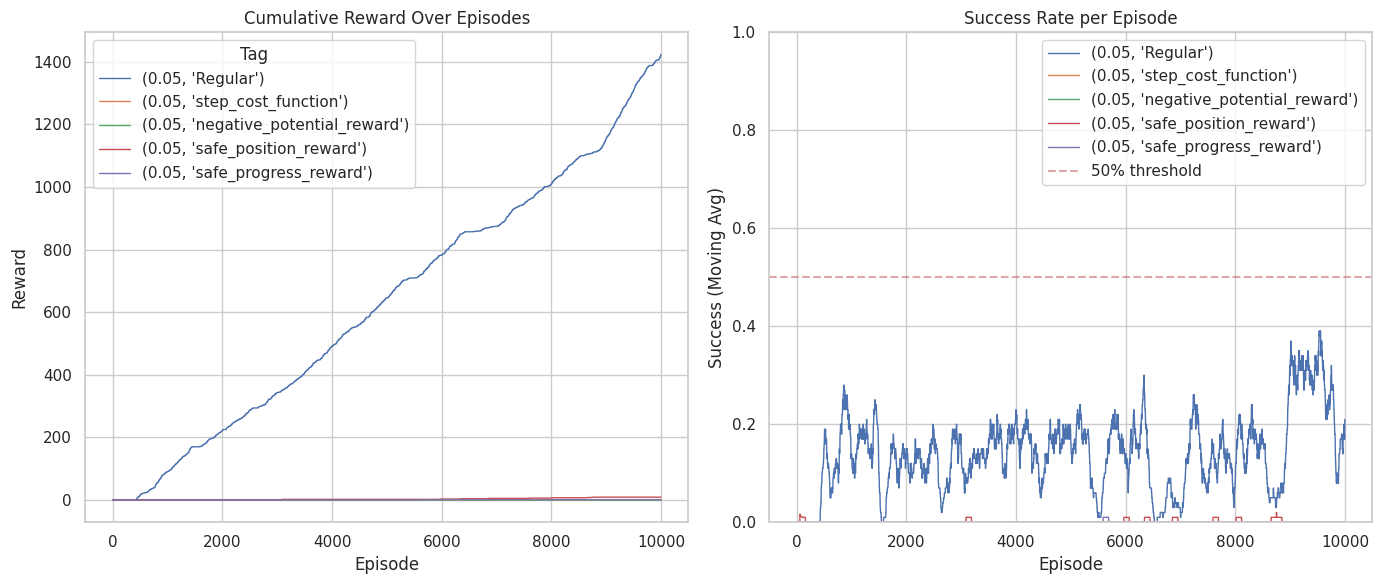

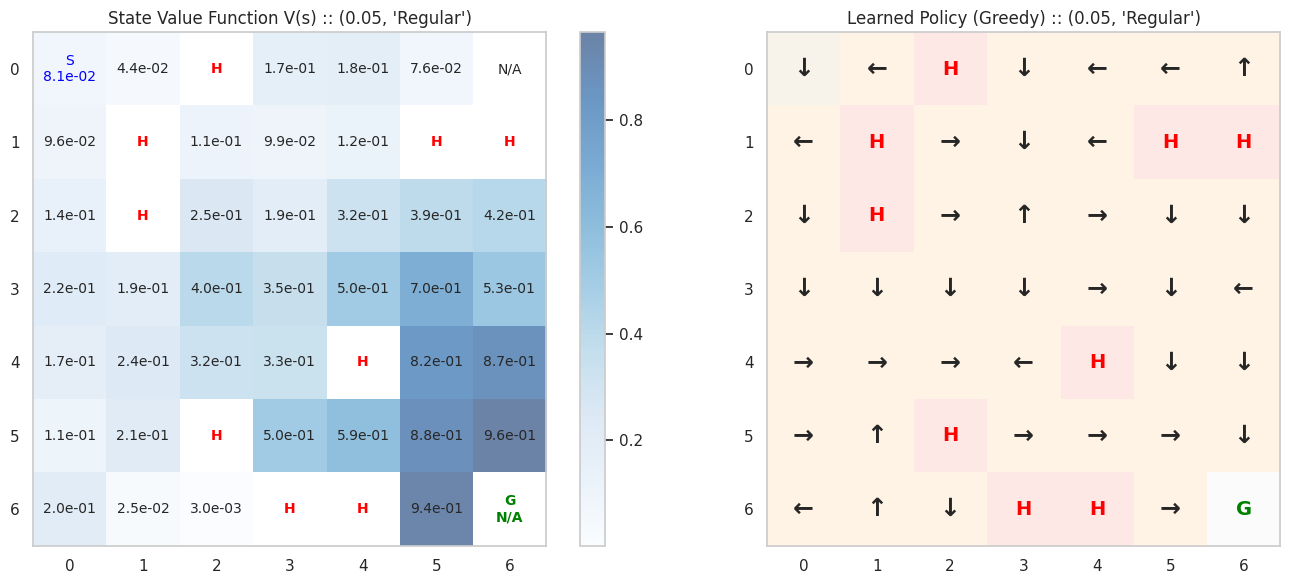

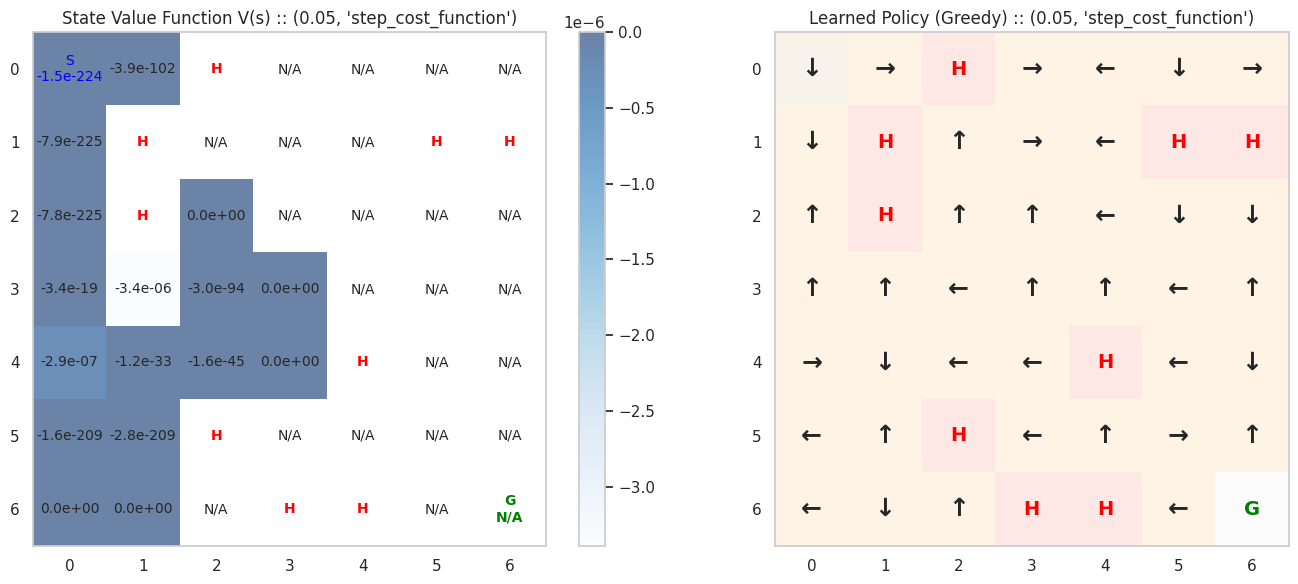

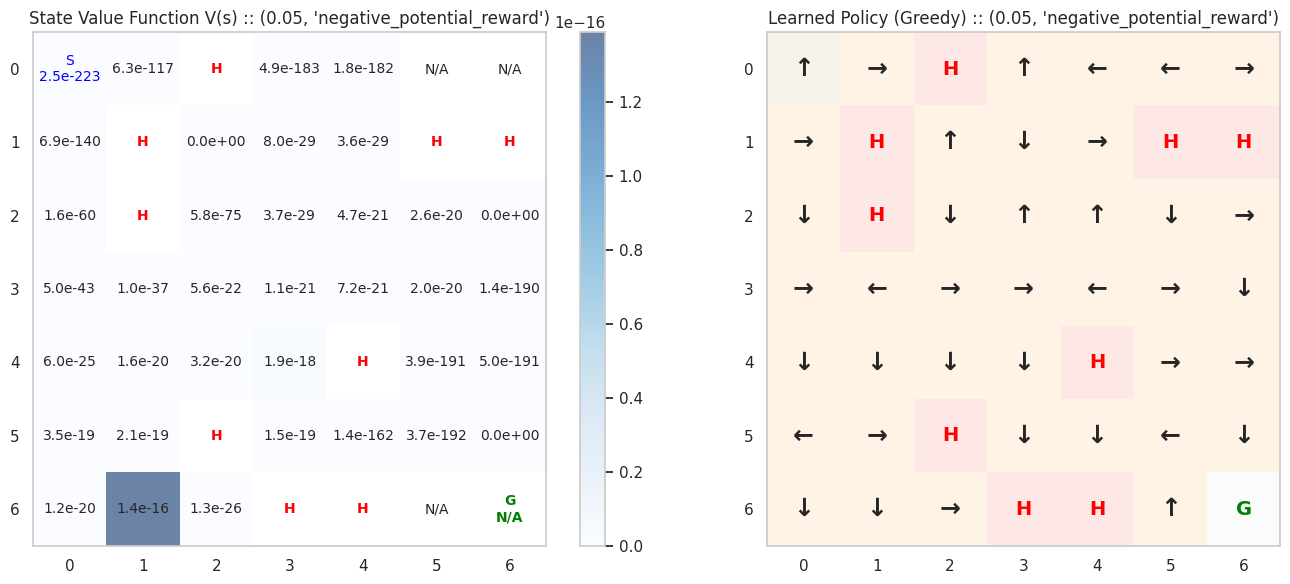

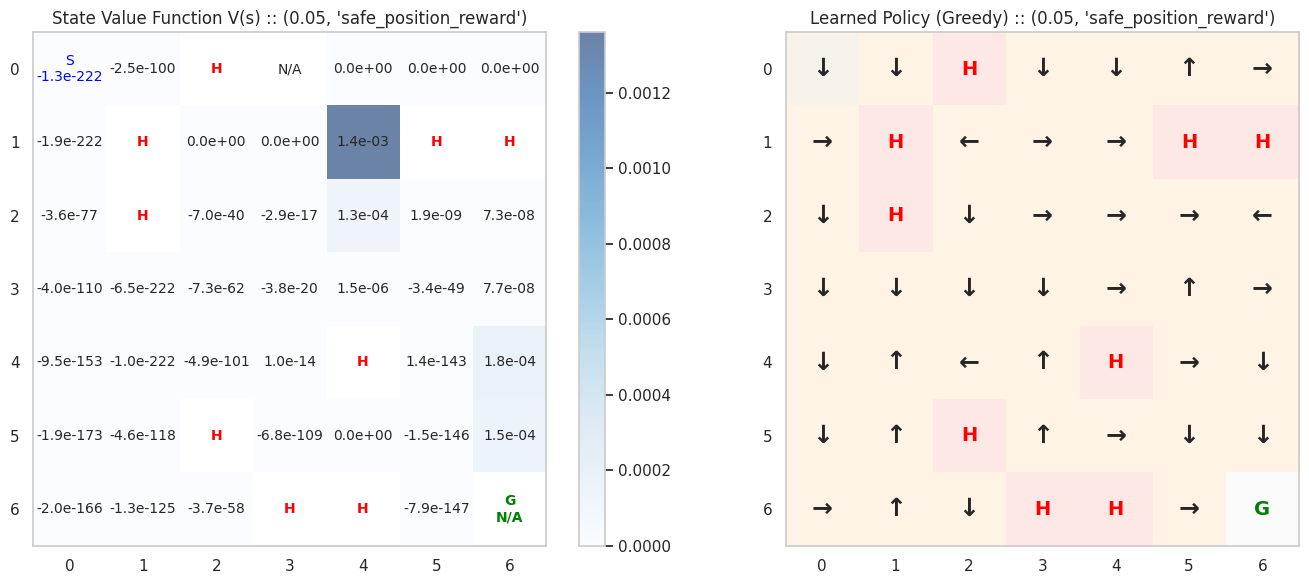

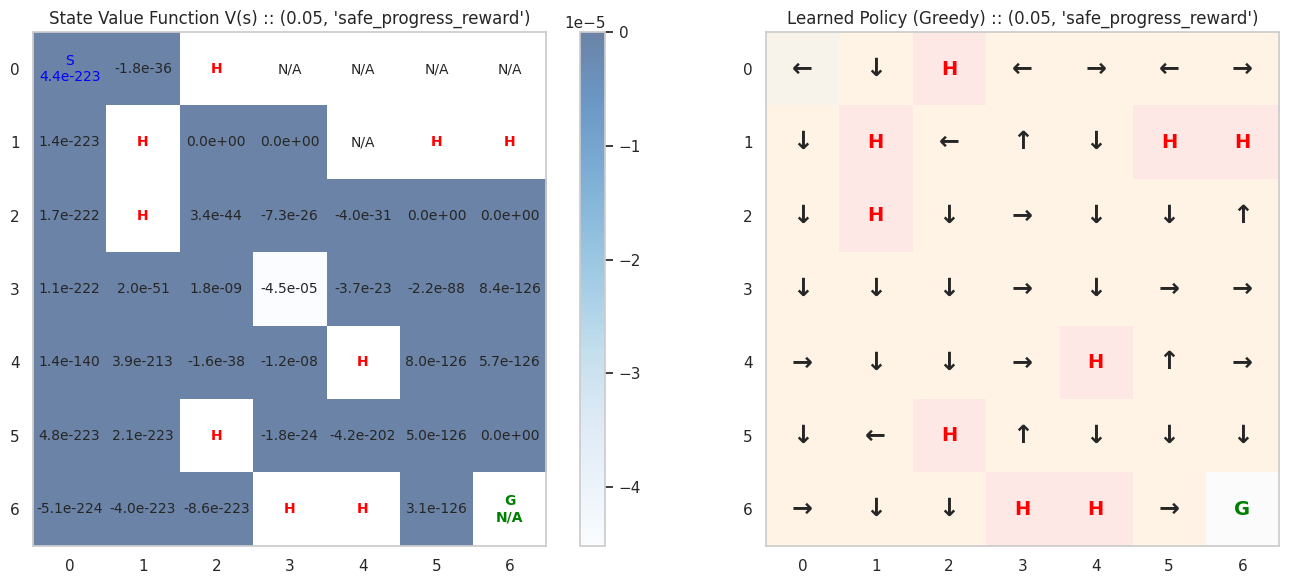







TRAINING CONFIGURATION
Agent Algorithm: MC
Learning rate (α): 0.1
Discount factor (γ): 0.95
Initial ε: 0.1
Minimum ε: 0.01
ε decay: 0.0
Episodes: 10,000
Max steps per episode: 200
Environment: Frozen Lake 7x7
Slippery dynamics: True
Shaping reward function: None
Shaping decay: 0.95
Shaping strength: 0.1

Starting training...

Episode    500 | Epsilon: 0.1000 | Recent Throughput Avg: 1.20% | Total Throughput Avg: 1.20%
Episode   1000 | Epsilon: 0.1000 | Recent Throughput Avg: 19.00% | Total Throughput Avg: 10.10%
Episode   1500 | Epsilon: 0.1000 | Recent Throughput Avg: 9.60% | Total Throughput Avg: 9.93%
Episode   2000 | Epsilon: 0.1000 | Recent Throughput Avg: 21.40% | Total Throughput Avg: 12.80%
Episode   2500 | Epsilon: 0.1000 | Recent Throughput Avg: 21.20% | Total Throughput Avg: 14.48%
Episode   3000 | Epsilon: 0.1000 | Recent Throughput Avg: 17.60% | Total Throughput Avg: 15.00%
Episode   3500 | Epsilon: 0.1000 | Recent Throughput Avg: 13.40% | Total Throughput Avg: 14.77

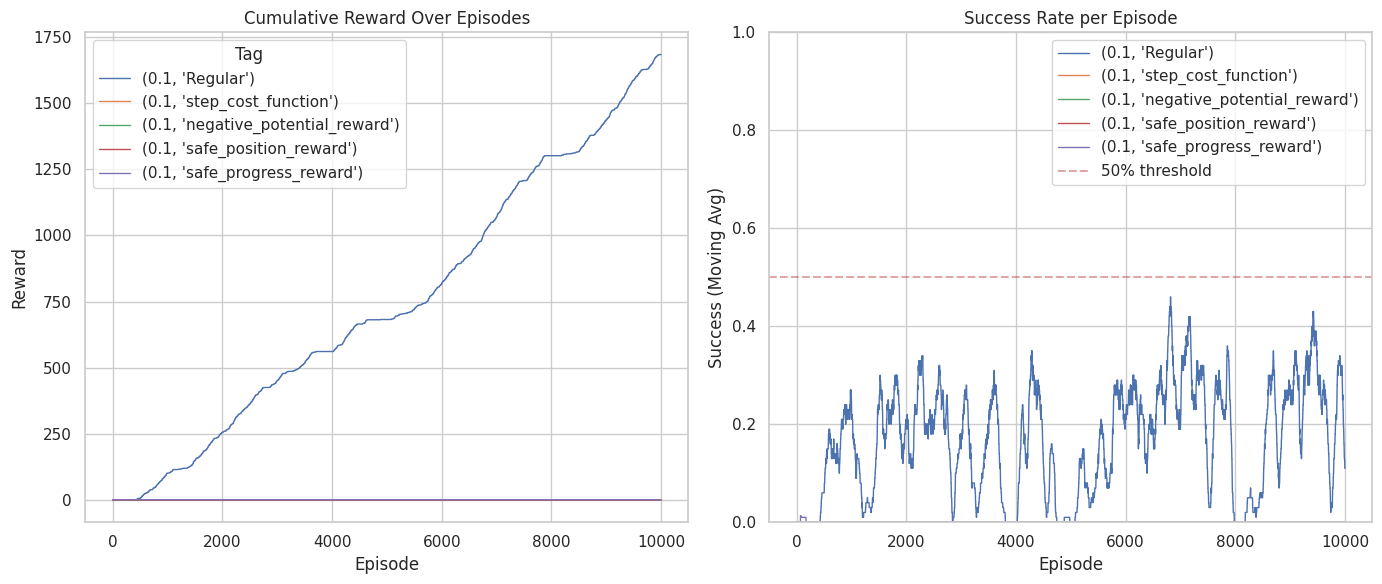

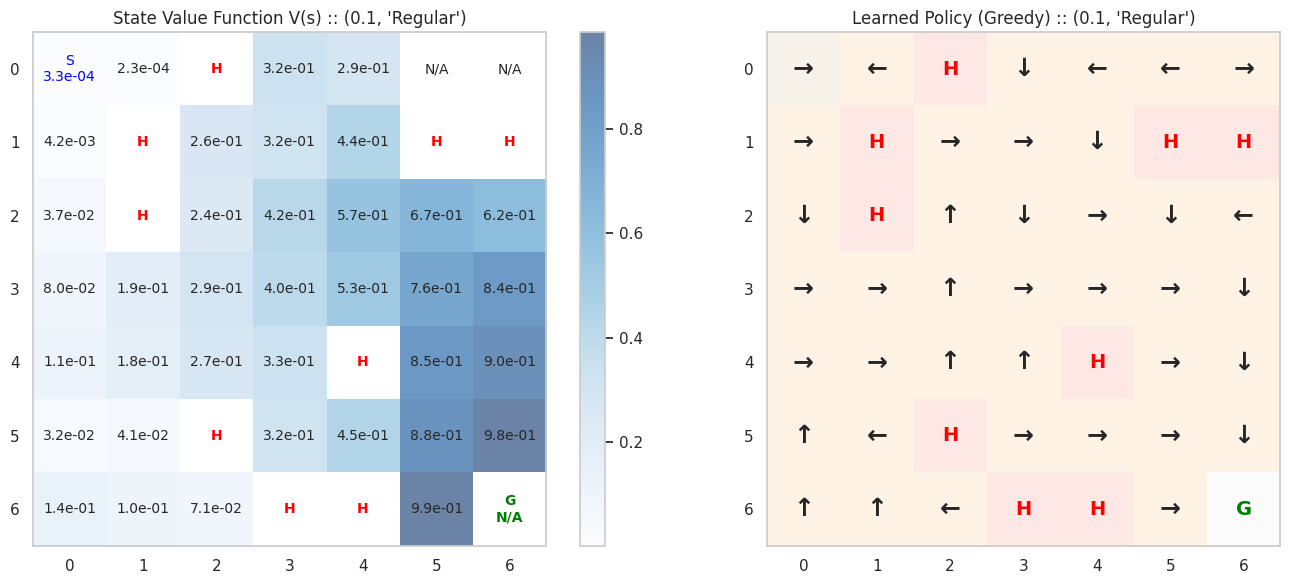

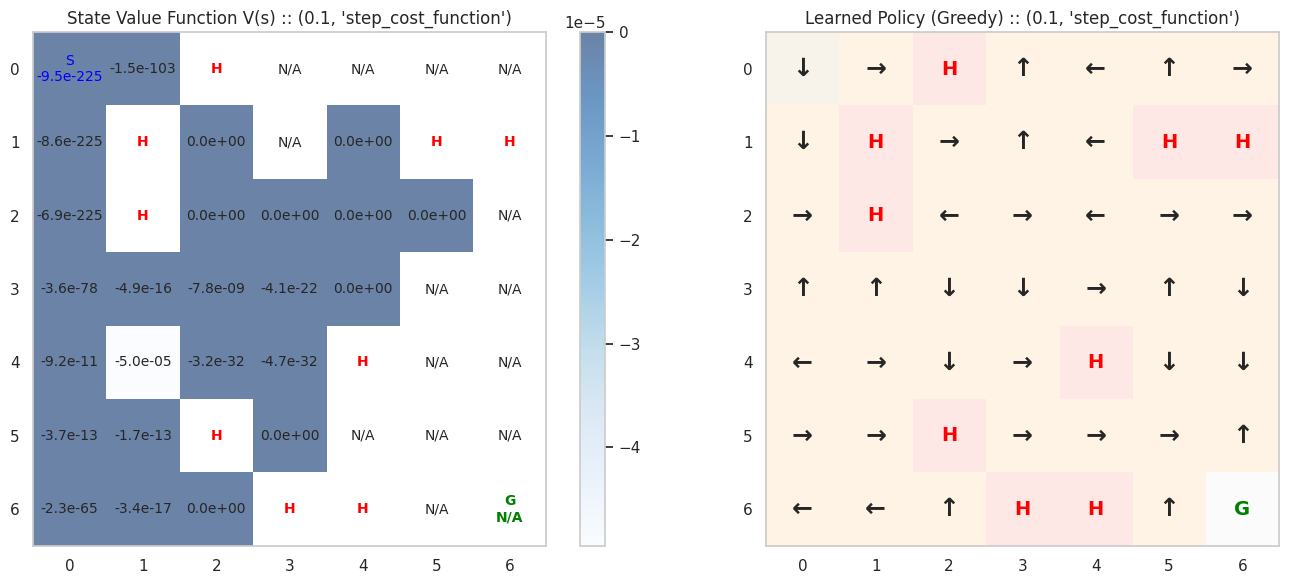

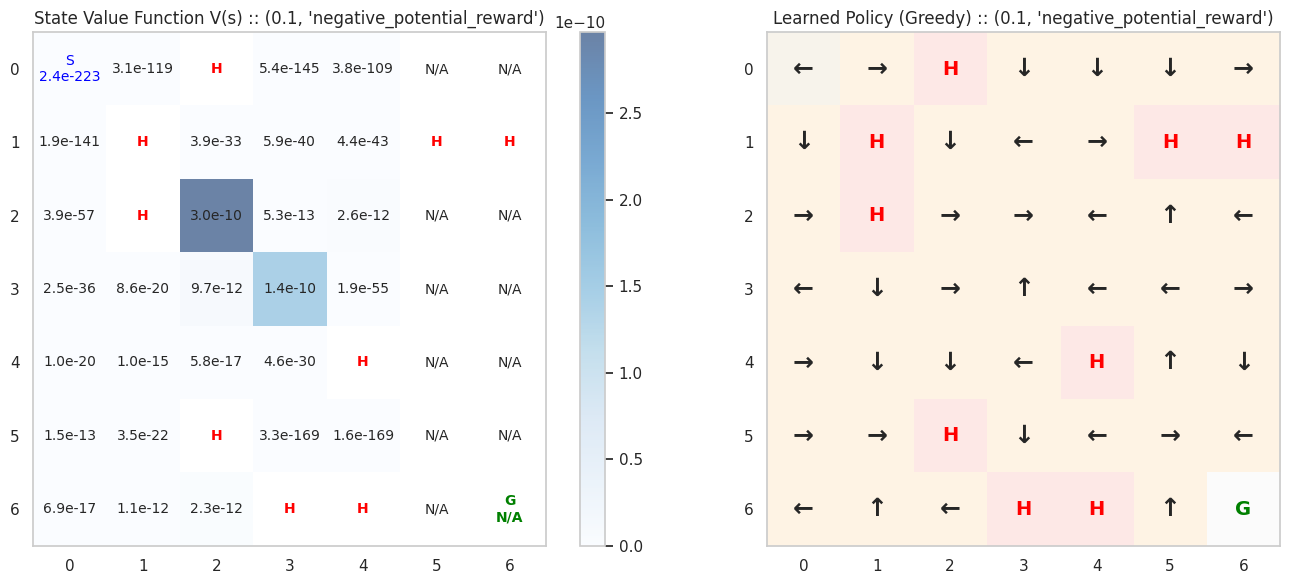

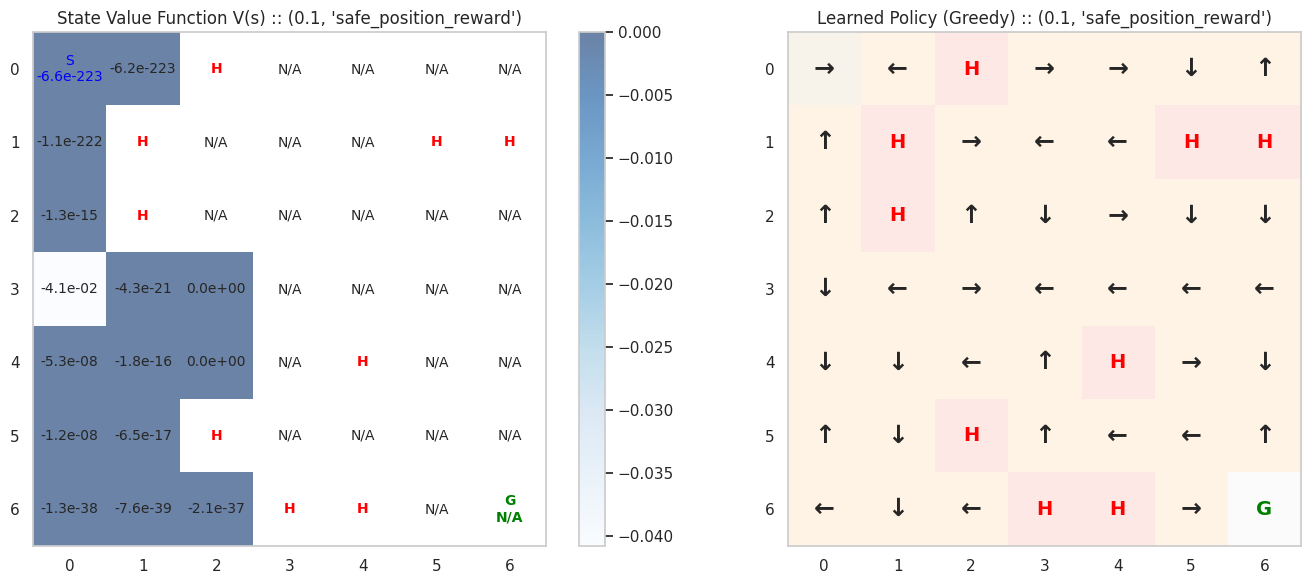

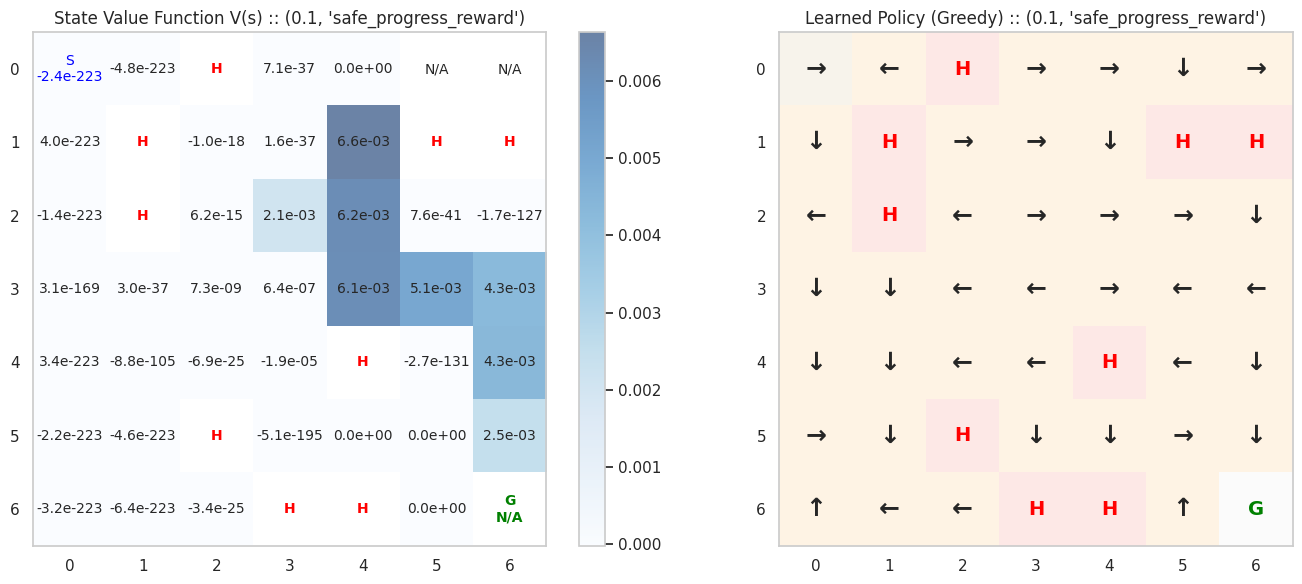







TRAINING CONFIGURATION
Agent Algorithm: MC
Learning rate (α): 0.1
Discount factor (γ): 0.95
Initial ε: 0.2
Minimum ε: 0.01
ε decay: 0.0
Episodes: 10,000
Max steps per episode: 200
Environment: Frozen Lake 7x7
Slippery dynamics: True
Shaping reward function: None
Shaping decay: 0.95
Shaping strength: 0.1

Starting training...

Episode    500 | Epsilon: 0.2000 | Recent Throughput Avg: 1.80% | Total Throughput Avg: 1.80%
Episode   1000 | Epsilon: 0.2000 | Recent Throughput Avg: 4.60% | Total Throughput Avg: 3.20%
Episode   1500 | Epsilon: 0.2000 | Recent Throughput Avg: 4.40% | Total Throughput Avg: 3.60%
Episode   2000 | Epsilon: 0.2000 | Recent Throughput Avg: 3.20% | Total Throughput Avg: 3.50%
Episode   2500 | Epsilon: 0.2000 | Recent Throughput Avg: 0.40% | Total Throughput Avg: 2.88%
Episode   3000 | Epsilon: 0.2000 | Recent Throughput Avg: 0.40% | Total Throughput Avg: 2.47%
Episode   3500 | Epsilon: 0.2000 | Recent Throughput Avg: 3.00% | Total Throughput Avg: 2.54%
Episode 

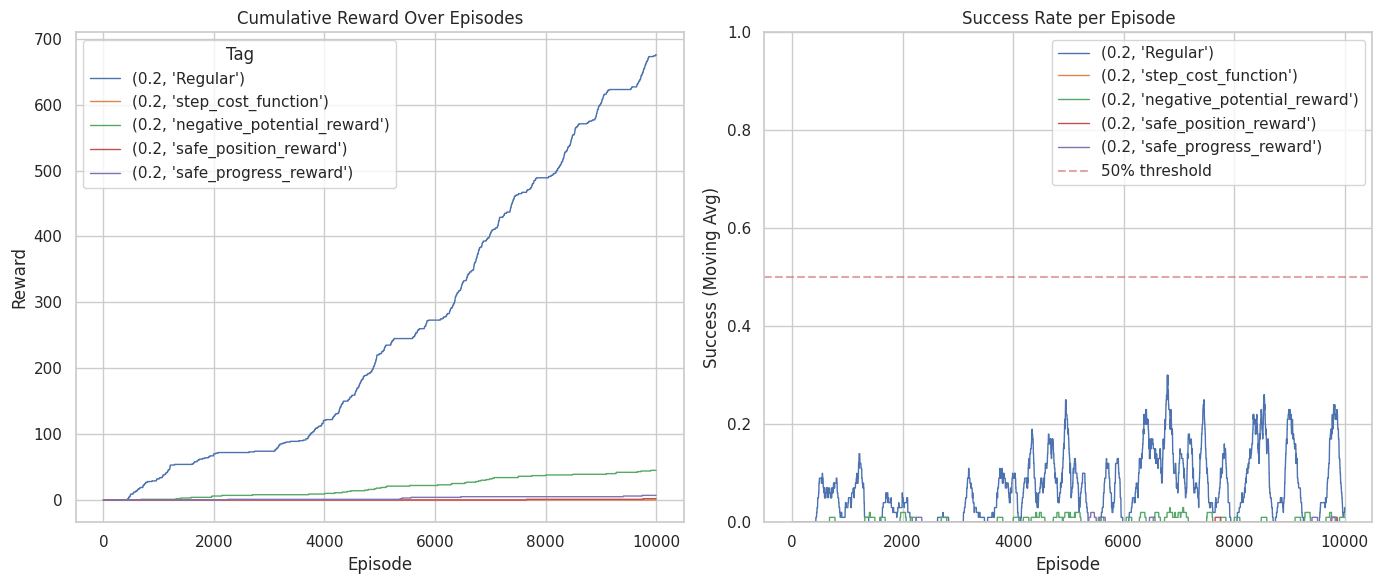

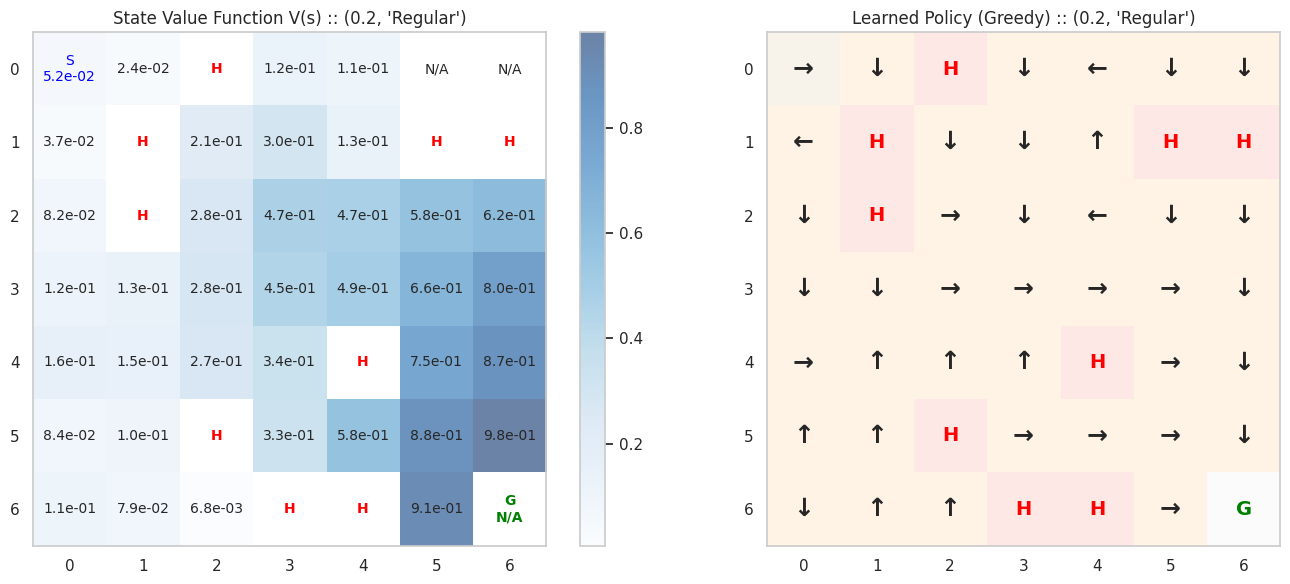

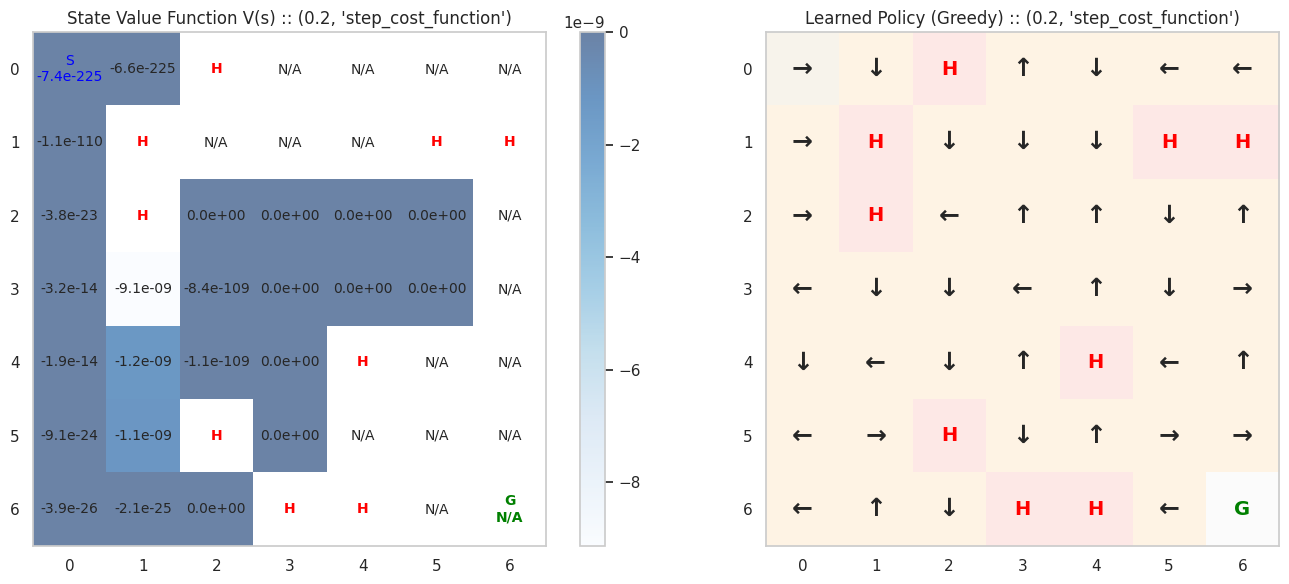

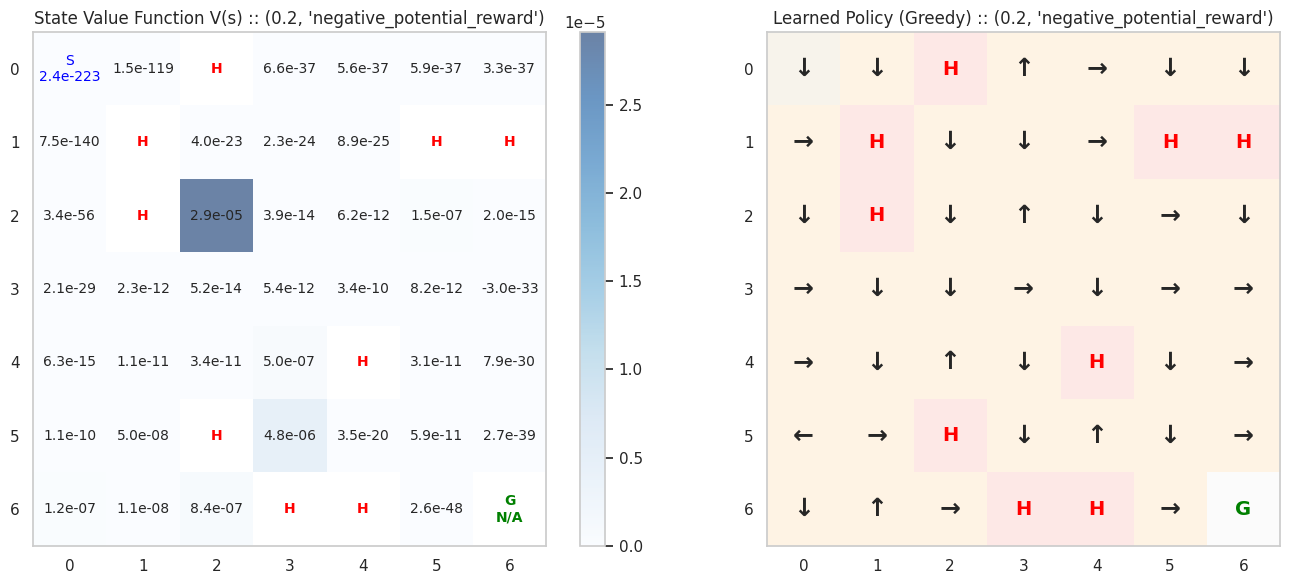

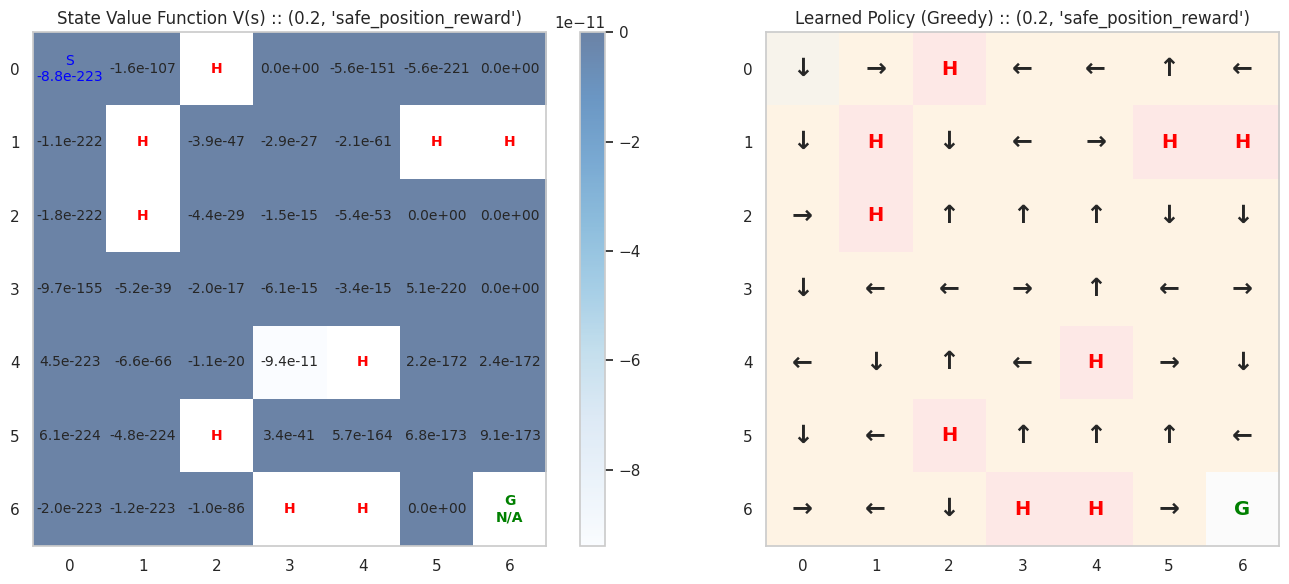

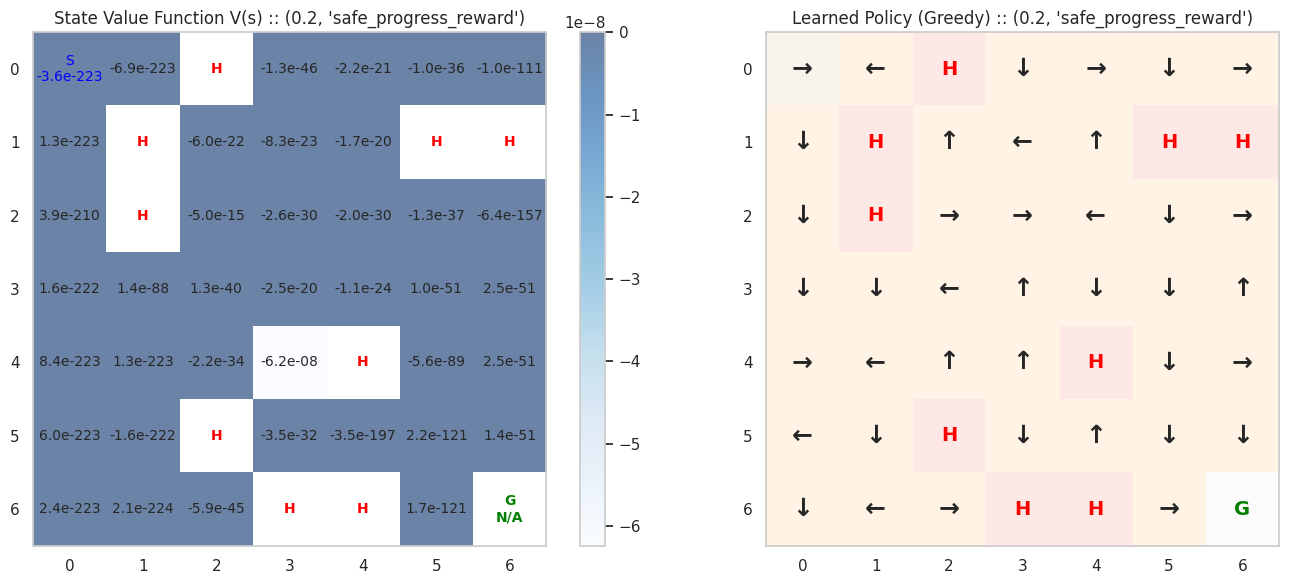

In [20]:
def main_mc():
  for eps in eps_arr:
    results = {}
    for shaping_reward_func in shaping_reward_func_arr:
      hyperparams = base_hyperparams.copy()
      hyperparams["epsilon_start"] = eps
      hyperparams["custom_reward_func"] = shaping_reward_func
      history, agent, map_desc = run_experiment(**hyperparams)
      func_name = shaping_reward_func.__name__ if shaping_reward_func else "Regular"
      results[(eps, func_name)] = (history, agent, map_desc)
      print("\n"*5)
      print("-"*20)
      print("\n"*5)

    display_graphs(results)
    print("="*20)
    print("\n"*5)

main_mc()


###Main SARSA(0)


TRAINING CONFIGURATION
Agent Algorithm: SARSA
Learning rate (α): 0.1
Discount factor (γ): 0.95
Initial ε: 0.2
Minimum ε: 0.01
ε decay: 0.0
Episodes: 10,000
Max steps per episode: 200
Environment: Frozen Lake 7x7
Slippery dynamics: True
Shaping reward function: None
Shaping decay: 0.95
Shaping strength: 0.1

Starting training...

Episode    500 | Epsilon: 0.2000 | Recent Throughput Avg: 0.20% | Total Throughput Avg: 0.20%
Episode   1000 | Epsilon: 0.2000 | Recent Throughput Avg: 0.00% | Total Throughput Avg: 0.10%
Episode   1500 | Epsilon: 0.2000 | Recent Throughput Avg: 0.00% | Total Throughput Avg: 0.07%
Episode   2000 | Epsilon: 0.2000 | Recent Throughput Avg: 0.00% | Total Throughput Avg: 0.05%
Episode   2500 | Epsilon: 0.2000 | Recent Throughput Avg: 0.00% | Total Throughput Avg: 0.04%
Episode   3000 | Epsilon: 0.2000 | Recent Throughput Avg: 0.00% | Total Throughput Avg: 0.03%
Episode   3500 | Epsilon: 0.2000 | Recent Throughput Avg: 0.00% | Total Throughput Avg: 0.03%
Episode   4

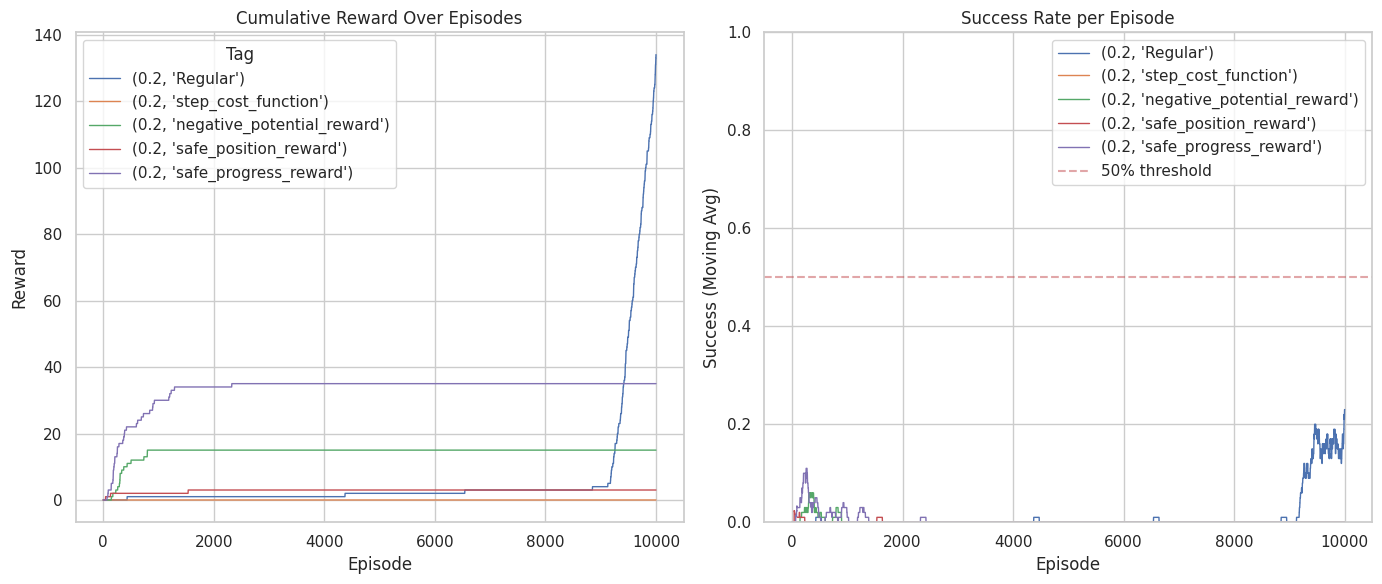

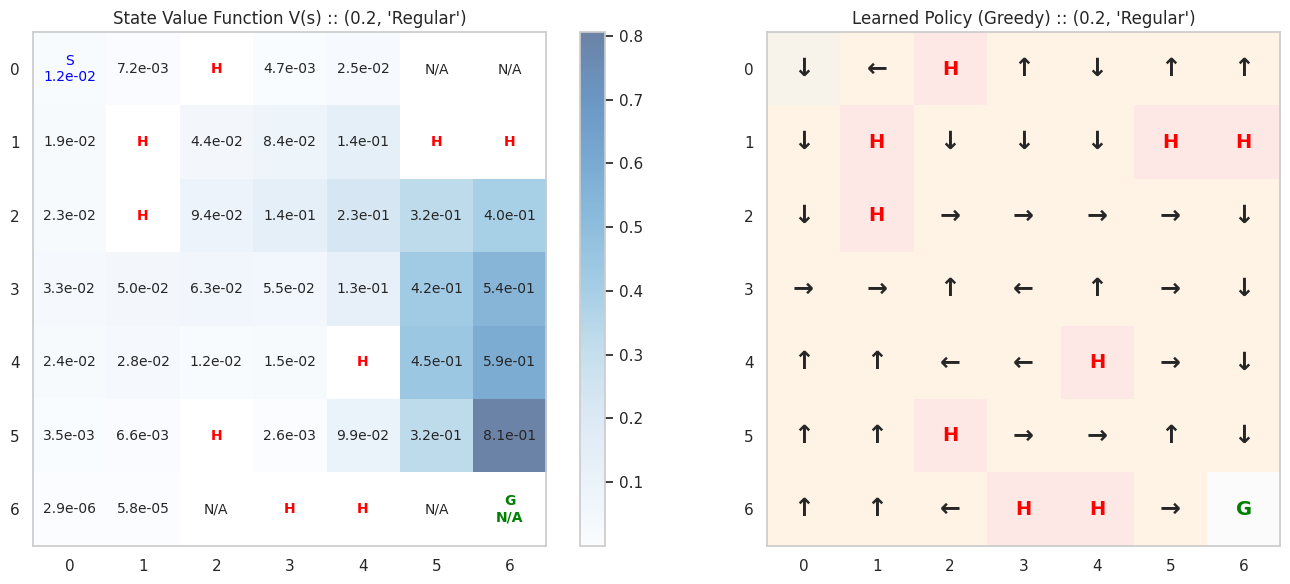

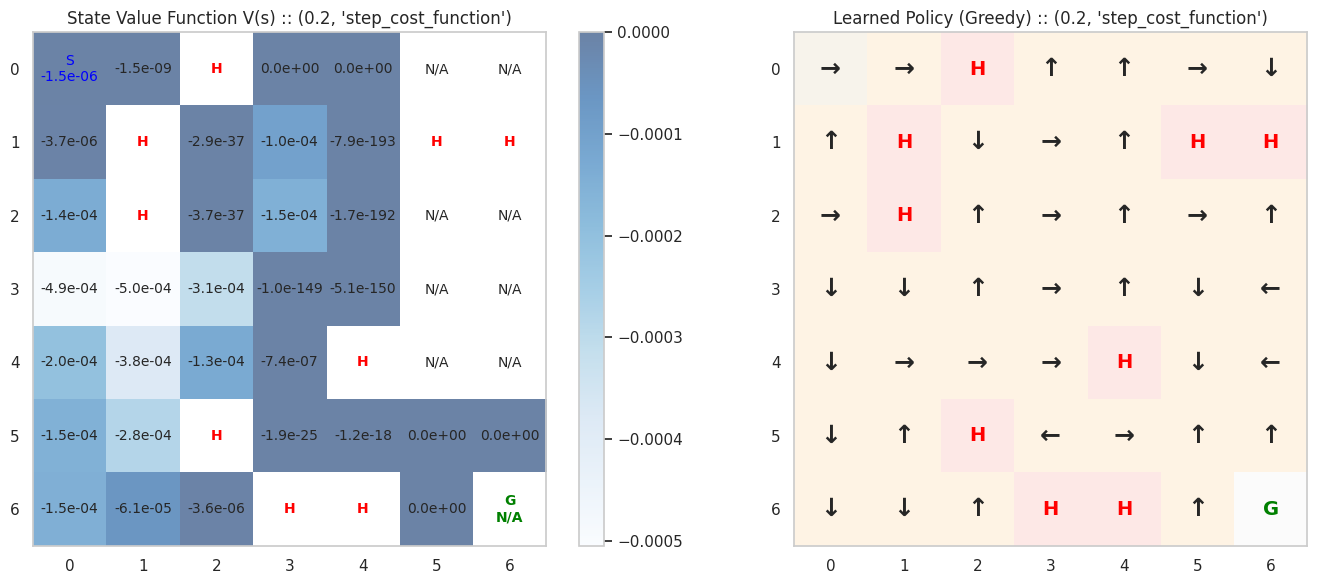

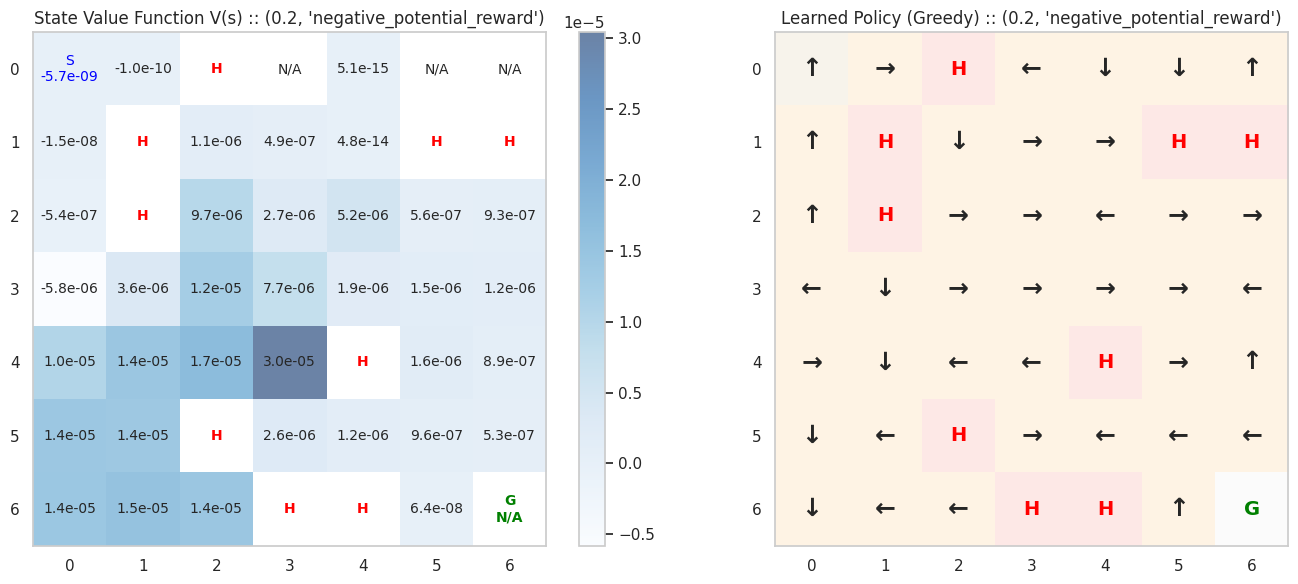

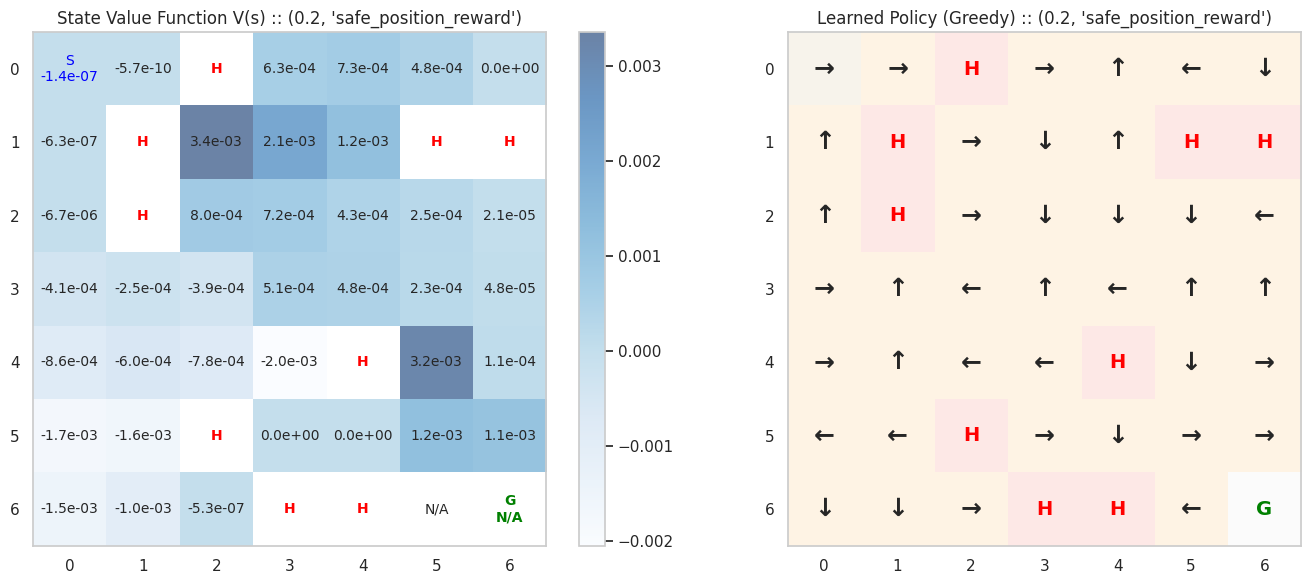

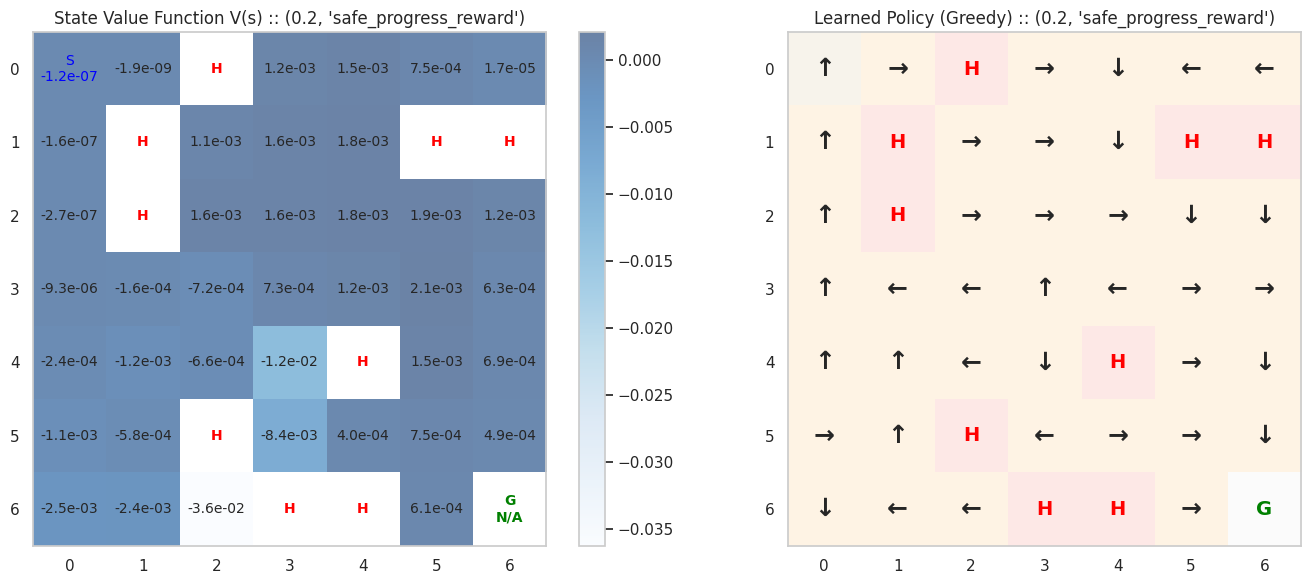

In [21]:
def main_sarsa():
    results = {}
    eps = 0.2
    for shaping_reward_func in shaping_reward_func_arr:
      hyperparams = base_hyperparams.copy()
      hyperparams["epsilon_start"] = eps
      hyperparams["agent_algo"] = "SARSA"
      hyperparams["custom_reward_func"] = shaping_reward_func
      history, agent, map_desc = run_experiment(**hyperparams)
      func_name = shaping_reward_func.__name__ if shaping_reward_func else "Regular"
      results[(eps, func_name)] = (history, agent, map_desc)
      print("\n"*5)
      print("-"*20)
      print("\n"*5)

    display_graphs(results)
    print("="*20)
    print("\n"*5)

main_sarsa()


# Test

In [22]:
# # Hyperparameters
# ALPHA = 0.1           # Learning rate (constant)
# GAMMA = 1.0           # Discount factor (as specified)
# EPSILON_START = 1.0   # Initial exploration rate
# EPSILON_MIN = 0.01    # Minimum exploration rate
# EPSILON_DECAY = 0.9995 # Decay rate per episode
# N_EPISODES = 20000    # Number of training episodes
# MAX_STEPS = 200       # Maximum steps per episode
# IS_SLIPPERY = True,
# MAP_SIZE_N = 7

## MC

In [23]:

# run_experiment(
#     agent_algo="MC",
#     alpha=ALPHA,
#     gamma=GAMMA,
#     epsilon_start=EPSILON_START,
#     epsilon_min=EPSILON_MIN,
#     epsilon_decay=EPSILON_DECAY,
#     n_episodes=N_EPISODES,
#     max_steps=MAX_STEPS,
#     is_slippery=IS_SLIPPERY,
#     # custom_reward_func_addon=RewardShapingWrapper.safe_progress_reward,  # optional, set earlier or keep default None
#     # shaping_strength=1,            # optional, set earlier or keep default 0.0
#     map_size_n = MAP_SIZE_N
# )


## SARSA(0)

In [24]:
# run_experiment(
#     agent_algo="SARSA",
#     alpha=ALPHA,
#     gamma=GAMMA,
#     epsilon_start=EPSILON_START,
#     epsilon_min=EPSILON_MIN,
#     epsilon_decay=EPSILON_DECAY,
#     n_episodes=N_EPISODES,
#     max_steps=MAX_STEPS,
#     custom_reward_func_addon=RewardShapingWrapper.negative_potential_reward,  # optional, set earlier or keep default None
#     shaping_strength=0.01            # optional, set earlier or keep default 0.0
# )
